In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# Data extraction

In [3]:
train_file = "./dataset/sign_mnist_train.csv"
test_file = "./dataset/sign_mnist_test.csv"


In [4]:
data = pd.read_csv(train_file,header=0)
test_data = pd.read_csv(test_file,header=0)

def parse_data(data):
    x = data.drop('label', axis=1).to_numpy()
    y = pd.DataFrame(data =  data['label'] , columns = ['label']).to_numpy()
    return x, y.ravel()
def lab2char(label):
    return chr( ord('a')  + label)

x,y = parse_data(data)
x_test, y_test = parse_data(test_data)

In [5]:
print(type(x), type(y) )
print(x.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(27455, 784) (27455,)


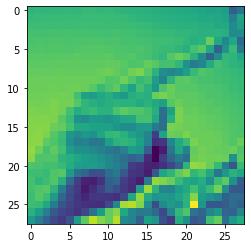

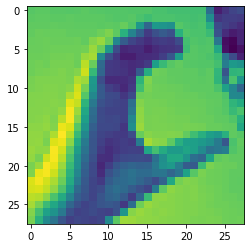

In [6]:
def vec2img(xi, dim = 28):
    return xi.reshape((dim,dim))

def show_image(img):
    plt.imshow(img)
    plt.show()
    
# print(lab2char( y[1]))
show_image(vec2img(x[1]))
show_image(vec2img(x[2]))

## Dimention Reduction

In [3]:
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pywt
import pywt.data
from numpy import imag


In [8]:
x_train_original = x
x_test_original = x_test


In [9]:
def Haar(imagen, cortes):
  for i in range(cortes):
    imagen, (LH, HL, HH) = pywt.dwt2(imagen, 'haar') 
  return imagen

def haar_reduction(X, cuts = 2):
    sample_img = vec2img(X[0])
    sample_haar = Haar(sample_img,cuts)
    features = len(sample_haar.ravel())
    rX = np.ones((np.shape(X)[0], features))
    for i, img in enumerate(X):
      # print(i)
      rX[i] = Haar(vec2img(img), cuts).ravel()

    return rX



In [10]:
x_reduce  = haar_reduction(x_train_original)
x_test_reduce  = haar_reduction(x_test_original)

In [11]:
print(x.shape, x_test.shape)

(27455, 784) (7172, 784)


## Clasification

In [4]:
# models
import imp
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import scipy

#score methods
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#metrics
import sklearn as sk
import sklearn.utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

#utils
import seaborn as sns
from sklearn.utils import resample
from math import ceil
from tqdm import tqdm
import matplotlib.pyplot as plt


In [13]:
def plot_scores(scores, xerr ,model_name = "DS", x_label = "depth"):
    yerr = [np.mean(score) for score in scores]
    err = [np.std(score) for score in scores]
    plt.style.use('seaborn-whitegrid')
    plt.errorbar(xerr, yerr, err, linestyle = 'dashed', fmt = 'o', ecolor='lightgray', elinewidth=3, capsize=0)
    plt.title(f'Error distribution for {model_name}')
    plt.ylabel('Error distribution')
    # plt.xlabel(x_label)

def cv_evaluate_model(models, X, y, name = "Classifier", kfolds = 10):
    scores = []
    for modelclf in tqdm(models,  leave=False, desc=f'cross predict for{name}'):
        kfold = KFold(n_splits = kfolds, shuffle= True)
        score = cross_val_score(estimator=modelclf, X=x, y=y, cv= kfold , n_jobs=-1)
        scores.append(score)
    return scores


In [14]:
print(x.shape, y.shape)
print(x_test.shape, y_test.shape)

(27455, 784) (27455,)
(7172, 784) (7172,)


In [15]:
def bias_variance_decomposition(y_pred, y_real):
    modal_predictions = scipy.stats.mode(y_pred, axis=0)[0][0]
    mean_loss = np.mean(y_pred != y_real)
    mean_bias = np.mean(modal_predictions != y_real)
    mean_var = np.mean(modal_predictions != y_pred)
    
    return mean_loss, mean_bias, mean_var


In [16]:
def cv_sample(X, y, folds = 10, random_state = 42):
    kfold = KFold(n_splits = folds, shuffle= True)
    return kfold.split(X,y)

def cross_validation(X, y, X_t, y_t, model, model_name = '', n_experiments = 10):
    presicion = np.zeros((n_experiments, 1))
    recall = np.zeros((n_experiments, 1))
    f1 = np.zeros((n_experiments, 1))
    auc = np.zeros((n_experiments, 1))
    loss = np.zeros((n_experiments, 1))
    bias = np.zeros((n_experiments, 1))
    var = np.zeros((n_experiments, 1))
 
    kfold = KFold(n_splits=  10, shuffle= True, random_state= 42)
    i = 0
    for train,test in tqdm(kfold.split(X), leave=False, total=kfold.get_n_splits(), desc=f"k-fold with {model_name}") :
        xb, yb  = x[train], y[train]
        clf  = model.fit(xb, yb)
        y_pred = clf.predict(X_t)
        #presicion
        presicion[i] = sklearn.metrics.precision_score(y_t, y_pred, average = 'micro')
        #recall
        recall[i]   = sklearn.metrics.recall_score(y_t, y_pred, average = 'macro')
        #f1 
        f1[i] = sklearn.metrics.f1_score(y_t, y_pred, average = 'macro')
        #aux
        y_pred_proba = clf.predict_proba(X_t)
        auc[i] = sklearn.metrics.roc_auc_score(y_test, y_pred_proba, multi_class = 'ovr')
        loss[i], bias[i], var[i] = bias_variance_decomposition(y_pred, y_t)
        i = i + 1
    
    df = pd.DataFrame(data=[[presicion.mean(), recall.mean(), f1.mean(), auc.mean(), loss.mean(), bias.mean(), var.mean()]], columns=['presicion', 'recall', 'f1', 'auc', 'loss', 'bias', 'var'])
    return df   


In [17]:
from pyexpat import model
from statistics import mode
from numpy import average
from sklearn import multiclass


def bs_sample(X,y, random_state = 42):    
    ind = np.array( [i for i in range(X.shape[0])] )
    sample = resample(ind, random_state = random_state)
    test_sample = np.delete(ind, sample)

    xb, yb = X[sample], y[sample] 
    xt ,yt  = X[test_sample] , y[test_sample]
    return xb, yb, xt, yt        

def Boostrap(X, y, X_t, y_t, model, model_name = '', n_experiments = 10):
    presicion = np.zeros((n_experiments, 1))
    recall = np.zeros((n_experiments, 1))
    f1 = np.zeros((n_experiments, 1))
    auc = np.zeros((n_experiments, 1))
    loss = np.zeros((n_experiments, 1))
    bias = np.zeros((n_experiments, 1))
    var = np.zeros((n_experiments, 1))


    for i in tqdm(range(n_experiments),  leave=False, desc=f'Boostraping {model_name}'):
        #fit 
        xb, yb, _, _ = bs_sample(X,y, 42 + 1)
        clf  = model.fit(xb, yb)
        #predict
        y_pred = clf.predict(X_t)
        #presicion
        presicion[i] = sklearn.metrics.precision_score(y_t, y_pred, average = 'micro')
        #recall
        recall[i]   = sklearn.metrics.recall_score(y_t, y_pred, average = 'macro')
        #f1 
        f1[i] = sklearn.metrics.f1_score(y_t, y_pred, average = 'macro')
        #aux
        y_pred_proba = clf.predict_proba(X_t)
        auc[i] = sklearn.metrics.roc_auc_score(y_t, y_pred_proba, multi_class = 'ovr')
        loss[i], bias[i], var[i] = bias_variance_decomposition(y_pred, y_t)
        i = i + 1
    

    df = pd.DataFrame(data=[[presicion.mean(), recall.mean(), f1.mean(), auc.mean(), loss.mean(), bias.mean(), var.mean()]], columns=['presicion', 'recall', 'f1', 'auc', 'loss', 'bias', 'var'])

    return df


# Testing

In [18]:
dst_changes =  [pow(2, i) for i in range(2, 8)]
dst_hyper = "Depth"
dst_models = [ tree.DecisionTreeClassifier(max_depth= i) for i in dst_changes]
dst_names  = [f"DST with max depth {i}"for i in dst_changes]

cnn_changes = [pow(2, i ) for i in range(2, 7)]
cnn_models = [ KNeighborsClassifier(n_neighbors = i, n_jobs= 4) for i in cnn_changes]
cnn_names  = [f"CNN with k {i}" for i in cnn_changes]
cnn_hyper = "Knn"


svm_changes = [pow(2, i ) for i in range(-1, 12,2)]
svm_models = [ svm.SVC(decision_function_shape='ovr', C = i, probability= True) for i in svm_changes]
svm_names  = [f"SVM with C {i}" for i in svm_changes]
svm_hyper = "C"

In [19]:
def test_models(X,y, Xt, yt, models, names, hyper,changes):
    df_lst = []
    for i, model in enumerate(tqdm(models , desc= "Testing models with k fold")):
        df_lst.append( cross_validation(X,y, Xt, yt , model, names[i])  )
        df_lst[-1]['sampling'] = "KFold"
        df_lst[-1][hyper] = changes[i]
    
    for i, model in enumerate(tqdm(models,desc= "Testing models with Boostrap")):
        df_lst.append( Boostrap(X,y, Xt, yt , model, names[i])  )
        df_lst[-1]['sampling'] = "Boostrap"
        df_lst[-1][hyper] = changes[i]

    return df_lst        


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import GaussianNB
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# x_reduce
# x_test_reduce
lda = LDA()
# scaler = MinMaxScaler()

x_reduce  = haar_reduction(x_train_original)
x_test_reduce  = haar_reduction(x_test_original)

x = lda.fit_transform(x_reduce, y)
x_test = lda.transform(x_test_reduce)

In [26]:
print(x_train_original.shape, x_test_original.shape)
print(x_reduce.shape, x_test_reduce.shape)
print(x.shape, x_test.shape)

(27455, 784) (7172, 784)
(27455, 49) (7172, 49)
(27455, 23) (7172, 23)


In [27]:
cnn_dfs = test_models(x, y, x_test, y_test, cnn_models, cnn_names, cnn_hyper, cnn_changes)
cnn_res = pd.concat(cnn_dfs, ignore_index= True)
cnn_res.sort_values(by=['presicion'], ascending=False).head()

Testing models with Boostrap: 100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


,presicion,recall,f1,auc,loss,bias,var,sampling,Knn
5,0.825711,0.825913,0.816281,0.919476,0.174289,0.930563,0.922895,Boostrap,4
1,0.825683,0.825455,0.816104,0.933680,0.174317,0.930563,0.923076,KFold,8
0,0.824526,0.824224,0.814634,0.923609,0.175474,0.930563,0.922574,KFold,4
6,0.824456,0.824376,0.814581,0.928371,0.175544,0.930563,0.923313,Boostrap,8
2,0.822699,0.822477,0.813540,0.952252,0.177301,0.930563,0.923187,KFold,16


In [197]:
dst_dfs = test_models(x, y, x_test, y_test, dst_models, dst_names, dst_hyper, dst_changes)
dst_res = pd.concat(dst_dfs, ignore_index= True)
dst_res.sort_values(by=['presicion'], ascending=False).head()

Testing models with Boostrap: 100%|██████████| 6/6 [01:02<00:00, 10.43s/it]


,presicion,recall,f1,auc,loss,bias,var,sampling,Depth
11,0.521640,0.506466,0.502875,0.742852,0.478360,0.944311,0.939668,Boostrap,128
4,0.517289,0.504532,0.501132,0.741791,0.482711,0.944325,0.937019,KFold,64
5,0.516230,0.501953,0.498604,0.740477,0.483770,0.942206,0.936656,KFold,128
2,0.516188,0.502668,0.500232,0.755660,0.483812,0.948299,0.935597,KFold,16
3,0.515937,0.504097,0.500076,0.741545,0.484063,0.939571,0.936893,KFold,32


In [198]:
svm_dfs = test_models(x, y , x_test, y_test , svm_models, svm_names, svm_hyper, svm_changes)
svm_res = pd.concat(svm_dfs, ignore_index= True)
svm_res.sort_values(by=['presicion'], ascending=False).head()

Testing models with Boostrap: 100%|██████████| 7/7 [32:56<00:00, 282.33s/it]


,presicion,recall,f1,auc,loss,bias,var,sampling,C
7,0.844255,0.839023,0.828873,0.985763,0.155745,0.930563,0.921082,Boostrap,0.5
8,0.844116,0.838833,0.829236,0.986678,0.155884,0.930563,0.921221,Boostrap,2.0
1,0.843126,0.837916,0.828136,0.986722,0.156874,0.930563,0.921277,KFold,2.0
0,0.841035,0.835471,0.825772,0.986306,0.158965,0.930563,0.922992,KFold,0.5
2,0.838553,0.833805,0.823553,0.986729,0.161447,0.930563,0.922476,KFold,8.0


In [77]:
svm_res.to_csv("res/svm1.csv", index = False)
cnn_res.to_csv("res/cnn1.csv", index = False)
dst_res.to_csv("res/dst1.csv", index = False)

## Result analysis

In [5]:
svm_res = pd.read_csv("res/svm1.csv")
cnn_res = pd.read_csv("res/cnn1.csv")
dst_res = pd.read_csv("res/dst1.csv")

In [76]:
cnn_res

,presicion,recall,f1,auc,loss,bias,var,sampling,Knn
0,0.824526,0.824224,0.814634,0.923609,0.175474,0.930563,0.922574,KFold,4
1,0.825683,0.825455,0.816104,0.933680,0.174317,0.930563,0.923076,KFold,8
2,0.822699,0.822477,0.813540,0.952252,0.177301,0.930563,0.923187,KFold,16
3,0.817206,0.815075,0.808111,0.965196,0.182794,0.930563,0.918949,KFold,32
4,0.775655,0.761638,0.763652,0.975214,0.224345,0.930563,0.909886,KFold,64
5,0.825711,0.825913,0.816281,0.919476,0.174289,0.930563,0.922895,Boostrap,4
6,0.824456,0.824376,0.814581,0.928371,0.175544,0.930563,0.923313,Boostrap,8
7,0.821249,0.822154,0.812278,0.945005,0.178751,0.930563,0.924568,Boostrap,16
8,0.814557,0.814523,0.806443,0.960783,0.185443,0.930563,0.920803,Boostrap,32
9,0.774819,0.765802,0.764073,0.974949,0.225181,0.930563,0.912716,Boostrap,64


In [65]:
cnn_res['Knn']

0     4
1     8
2    16
3    32
4    64
5     4
6     8
7    16
8    32
9    64
Name: Knn, dtype: int64

In [82]:
svm_res

,presicion,recall,f1,auc,loss,bias,var,sampling,C
0,0.841035,0.835471,0.825772,0.986306,0.158965,0.930563,0.922992,KFold,0.5
1,0.843126,0.837916,0.828136,0.986722,0.156874,0.930563,0.921277,KFold,2.0
2,0.838553,0.833805,0.823553,0.986729,0.161447,0.930563,0.922476,KFold,8.0
3,0.831693,0.827117,0.816439,0.986750,0.168307,0.930563,0.921319,KFold,32.0
4,0.831107,0.826571,0.815828,0.986717,0.168893,0.930563,0.921305,KFold,128.0
5,0.831107,0.826571,0.815828,0.986719,0.168893,0.930563,0.921305,KFold,512.0
6,0.831107,0.826571,0.815828,0.986722,0.168893,0.930563,0.921305,KFold,2048.0
7,0.844255,0.839023,0.828873,0.985763,0.155745,0.930563,0.921082,Boostrap,0.5
8,0.844116,0.838833,0.829236,0.986678,0.155884,0.930563,0.921221,Boostrap,2.0
9,0.834635,0.829696,0.819324,0.987230,0.165365,0.930563,0.921919,Boostrap,8.0


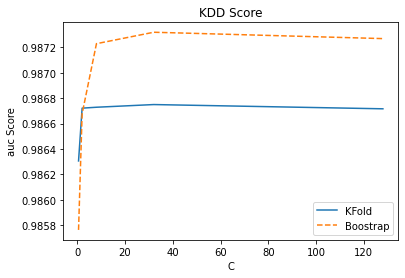

In [81]:
from matplotlib.lines import lineStyles


def plot_res(df, score_type = "f1", hyper  = "Depth"):
    data =  df[df['sampling'] == "KFold"][ [score_type, hyper]]
    data_b =  df[df['sampling'] == "Boostrap"][ [score_type, hyper]]
    x = data[score_type][0:5]
    y = data[hyper][0:5]
    xb = data_b[score_type][0:5]
    yb = data_b[hyper][0:5]

    plt.title("KDD Score")
    plt.xlabel(hyper)
    plt.ylabel(f"{score_type} Score")

    plt.plot(y, x, label = "KFold")
    plt.plot(yb, xb, label = "Boostrap", linestyle = "--")
    plt.legend()
    plt.show()

plot_res(svm_res, score_type = "auc", hyper= "C")
# plt.plot()
# plt.show()

In [ ]:
tmod = svm.SVC(decision_function_shape='ovr', C = i, probability= True) 